# Transfromer Framework

起初 Transformer 是用于提升 **机器翻译任务** 性能而设计的。

设 Transformer 参数为 $\theta$, 其数据为

- 原语言token序列 $(x_1,x_2,x_3,\ldots,x_m)$
- 目标语言token序列 $(y_1,y_2,y_3,\ldots,y_n)$

语言模型是概率模型 

$$
p_\theta(y|x)
$$

本notebook，在不引入模型细节下，讲解 Transformer 框架。

## 模型

思考我们所接触的两种模型：

1. 分类模型：输入 token 序列， 输出分类类别的概率分布
2. word2vec：输入 单个 token，输出 预测 词表所有 token 的概率分布

在 transformer 模型中，我们参考 2，即

概率语言模型：输入 token 序列， 输出 预测 词表所有 token 的概率分布， 选取概率最大 token， 进行输出 **1个token**

所以问题来了：我们的 目标语言 label 是多个 $(y_1,y_2,y_3,\ldots,y_n)$，如何构造训练任务？

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

seq_src = 3
seq_trg = 4
vocab_size = 10
dim = 8

# 准备数据
src_ids = torch.randint(0, vocab_size, (1, seq_src))
trg_ids = torch.randint(0, vocab_size, (1, seq_trg))
print(src_ids)
print(trg_ids)

tensor([[2, 7, 6]])
tensor([[4, 6, 5, 0]])


In [4]:
class TransformerSimplestModel(nn.Module):
    """
    输入 token id 序列, 分类头预测一个 token
    输入:[bs, seq_len]
    输出:[bs, 1, vocab_size]
    """
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)
        self.head = nn.Linear(dim, vocab_size)
        
    def forward(self, x):
        X = self.embedding(x)
        X = X.mean(dim = 1) # 序列表征
        print(X.shape)
        logits = self.head(X)
        return logits
    
model_simplest = TransformerSimplestModel(vocab_size, dim)
logits = model_simplest(src_ids)
print(logits.shape)
pred = F.softmax(logits, dim = -1)
print(pred)
y_id = torch.argmax(pred[0,:])
print(y_id)

torch.Size([1, 8])
torch.Size([1, 10])
tensor([[0.1732, 0.0891, 0.0617, 0.1047, 0.0945, 0.1176, 0.1078, 0.0851, 0.1014,
         0.0650]], grad_fn=<SoftmaxBackward0>)
tensor(0)


上述模型实际上是预测一个概率分布：
$$
p_\theta(\cdot|x) \in \mathbb{R}^ {|V|}
$$
其中, $|V|$ 是词表大小

## 自回归

自回归是依赖历史数据，预测当前时刻数据的一种机器学习任务。

对于时序数据，$x'_t =  f_\theta(x_{0:t-1})$

求均方误差： $L = (x_t - x'_t)^2$ 

In [172]:
import torch.optim as optim
class AutoRegressive(nn.Module):
    def __init__(self, hidden = 512):
        super().__init__()
        self.W_up = nn.Linear(1, hidden)
        # self.act = nn.Sigmoid()
        self.W_down = nn.Linear(hidden, 1)
    def forward(self, X):
        _, n, _ = X.shape
        h = self.W_up(X)
        f = h.mean(dim = 1) + h[:, n-1, :] 
        y = self.W_down(f)
        return y

def generate_time_series(length = 512, n = 100):
    t = torch.arange(0, length)
    random = torch.randn(3, n)
    noisy = torch.randn(length, n) / 3
    samples = []
    for i in range(n):
        sample = torch.sin( t * 0.02 + random[0,i]) * torch.cos(t * 0.02 * random[1,i])  + noisy[:,i]
        samples.append(sample.tolist())
    return samples

data = generate_time_series()
X = torch.tensor(data)
print(X.shape)

model = AutoRegressive(hidden = 64)
optimizer = optim.SGD(model.parameters(), lr = 1e-3)
loss_fn = nn.MSELoss()
print(model)

model(torch.randn(1,3,1))

torch.Size([100, 512])
AutoRegressive(
  (W_up): Linear(in_features=1, out_features=64, bias=True)
  (W_down): Linear(in_features=64, out_features=1, bias=True)
)


tensor([[0.6605]], grad_fn=<AddmmBackward0>)

In [173]:
for j in range(1, 4):
    print(j)

1
2
3


In [176]:
for i in range(10):
    optimizer.zero_grad()

    Y_preds = torch.zeros(100, 511)
    for j in range(0, 511):
        Y_pred = model(X[:,:j+1].unsqueeze(dim = 2))
        Y_preds[:,j] = Y_pred[:,0]
    loss = loss_fn(Y_preds, X[:,1:])
    loss.backward()
    print(loss)
    optimizer.step()

tensor(0.3426, grad_fn=<MseLossBackward0>)
tensor(0.3197, grad_fn=<MseLossBackward0>)
tensor(0.3034, grad_fn=<MseLossBackward0>)
tensor(0.2914, grad_fn=<MseLossBackward0>)
tensor(0.2824, grad_fn=<MseLossBackward0>)
tensor(0.2754, grad_fn=<MseLossBackward0>)
tensor(0.2697, grad_fn=<MseLossBackward0>)
tensor(0.2650, grad_fn=<MseLossBackward0>)
tensor(0.2609, grad_fn=<MseLossBackward0>)
tensor(0.2573, grad_fn=<MseLossBackward0>)


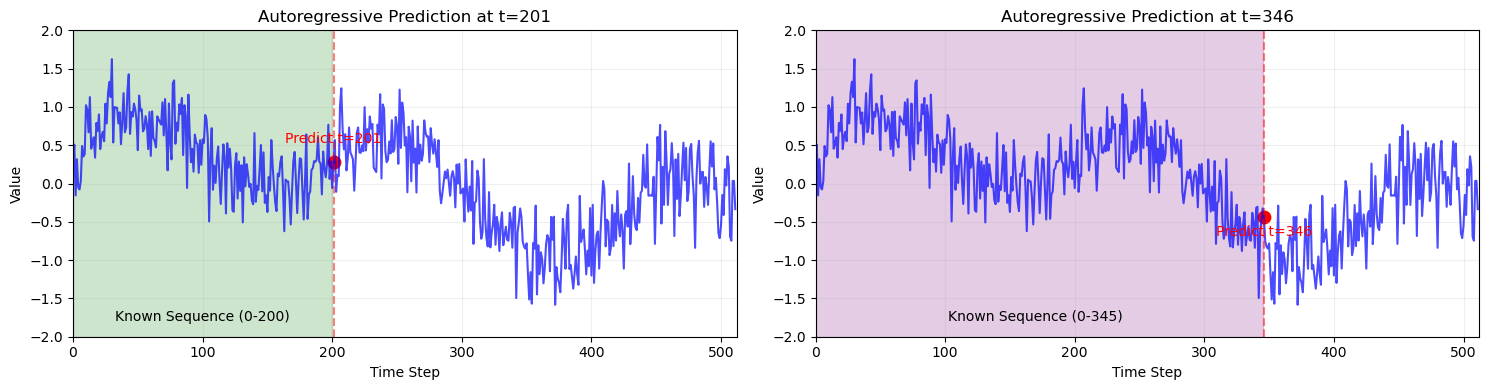

In [119]:
# 仅看图：通过历史 t[0~200] 预测 t[201], 数据即是输入，也是标签
import matplotlib.pyplot as plt


# 创建横向排列的两个子图
plt.figure(figsize=(15, 4))

# 第一张图: 预测t=201
plt.subplot(1, 2, 1)
plt.plot(y, 'b-', alpha=0.7)
plt.axvspan(0, 200, color='green', alpha=0.2)  # 已知区域
plt.scatter(201, y[201], color='red', s=80)    # 预测点
plt.axvline(201, color='r', linestyle='--', alpha=0.5)

# 添加标注
plt.text(100, -1.8, 'Known Sequence (0-200)', ha='center', fontsize=10)
plt.text(201, y[201]+0.25, 'Predict t=201', ha='center', color='r', fontsize=10)

# 设置图形属性
plt.title('Autoregressive Prediction at t=201', fontsize=12)
plt.xlabel('Time Step', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.xlim(0, 512)
plt.ylim(-2, 2)
plt.grid(alpha=0.2)

# 第二张图: 预测t=346
plt.subplot(1, 2, 2)
plt.plot(y, 'b-', alpha=0.7)
plt.axvspan(0, 345, color='purple', alpha=0.2)  # 已知区域
plt.scatter(346, y[346], color='red', s=80)     # 预测点
plt.axvline(346, color='r', linestyle='--', alpha=0.5)

# 添加标注
plt.text(170, -1.8, 'Known Sequence (0-345)', ha='center', fontsize=10)
plt.text(346, y[346]-0.25, 'Predict t=346', ha='center', color='r', fontsize=10)

# 设置图形属性
plt.title('Autoregressive Prediction at t=346', fontsize=12)
plt.xlabel('Time Step', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.xlim(0, 512)
plt.ylim(-2, 2)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

## 训练任务

上述关于“输入序列”所预测的 token 到底有什么含义？我们假设它是我们预测的第 $y_1$

基于此我们写出预测模型
$$
y_1 \sim p_\theta(\cdot|x) \in \mathbb{R}^ {|V|}
$$
或
$$
p_\theta(y_1|x) \in \mathbb{R}^ {1}
$$

那么 $y_2$ 如何预测，可以利用$(x, y_1)$ 信息预测：

$$
p_\theta(y_{t+1}|x, y_{1:t}) ,t = 1,2,3,\ldots,n-1
$$

这种通过历史 token 信息，预测 下一个词元 信息的任务，称之为“next token predicition”

实际上更准确的说法为 “next token probability prediction” : **下一个词元概率预测**





In [32]:
# next-token-prediction

class TransformerGenerateModel(nn.Module):
    """
    输入 token id 序列, 分类头预测一个 token
    输入:[bs, seq_len]
    输出:[bs, 1, vocab_size]
    """
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)
        self.embedding_trg = nn.Embedding(vocab_size, dim)
        self.head = nn.Linear(dim, vocab_size)
        
    def forward(self, x, y):
        X = self.embedding(x)
        X = X.mean(dim = 1) # 序列表征
        Y = torch.zeros_like(X)
        if y is not None:
            Y = self.embedding_trg(y)
            Y = Y.mean(dim = 1)
        logits = self.head(X + Y) # 通过 融合 信息
        return logits


model_generate = TransformerGenerateModel(vocab_size, dim)
logits_list = []
for i in range(seq_trg):
    if i == 0:
        logits = model_generate(src_ids, None)
    else:
        # trg_ids[:i] 已知, 从label中而来
        logits = model_generate(src_ids, trg_ids[:i]) 
    logits_list.append(logits)

loss_fn = nn.CrossEntropyLoss()
logits = torch.concat(logits_list, dim = 0)
print(logits.shape)
print(trg_ids.shape)

loss = loss_fn(logits, trg_ids[0])
print(loss)

torch.Size([4, 10])
torch.Size([1, 4])
tensor(2.2908, grad_fn=<NllLossBackward0>)


## 推理任务

In [40]:
# 非训练阶段
# 如果trg_ids未知
y_pred = [[]]


for i in range(seq_trg):
    if len(y_pred) == 0:
        logits = model_generate(src_ids, None)
    else:
        # trg_ids[:i] 已知, 从label中而来
        logits = model_generate(src_ids, 
                                torch.tensor(y_pred, dtype=torch.long))
    pred = F.softmax(logits, dim = -1)
    y_id = torch.argmax(pred, dim = -1)
    y_pred[0].append(y_id.item())
    
print(trg_ids)
print(y_pred) # 推理阶段
    

tensor([[4, 6, 5, 0]])
[[0, 8, 8, 8]]


## Transformer 并行训练特性

In [43]:
# global X
X = torch.randn( 1, 1, dim)
Y = torch.randn( 1, seq_trg, dim)
print((X+Y).shape)

torch.Size([1, 4, 8])


In [67]:

class TransformerModel(nn.Module):
    """
    输入 token id 序列, 分类头预测一个 token
    输入:[bs, seq_len]
    输出:[bs, 1, vocab_size]
    """
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)
        self.embedding_trg = nn.Embedding(vocab_size, dim)
        self.head = nn.Linear(dim, vocab_size)
        
    def forward(self, x, y):
        X = self.embedding(x)
        X_mean = X.mean(dim = 1, keepdim=True) # 序列序列表征
        print(X_mean.shape)
        
        Y_0 = torch.zeros_like(X_mean)
        print(Y_0.shape)
        if y is not None:
            Y = self.embedding_trg(y)
            print(Y.shape)
            Y = torch.concat((Y_0, Y), dim = 1,)
            Y_mean = Y.mean(dim = 1)
            
        logits = self.head( Y + X_mean + Y_mean ) # 通过 融合 信息
        return logits

# x1, x2, x3, x4, y1, y2, y3, y4
# -,  -,  -,  y1, y2, y3, y4, -

model = TransformerModel(vocab_size, dim)
logits = model(src_ids, trg_ids)
print(logits.shape)

fix_logits = logits[:, :-1, :]
print(fix_logits.shape)
print(trg_ids.shape)

loss_fn(fix_logits[0,:,:], trg_ids[0,:])

torch.Size([1, 1, 8])
torch.Size([1, 1, 8])
torch.Size([1, 4, 8])
torch.Size([1, 5, 10])
torch.Size([1, 4, 10])
torch.Size([1, 4])


tensor(2.7289, grad_fn=<NllLossBackward0>)

## Encoder-Decoder-Transformer

In [73]:
class TransformerEncoderDecoderModel(nn.Module):
    """
    输入 token id 序列, 分类头并行预测多个 token
    输入:[bs, src_seq_len]
    输出:[bs, trg_seq_len, vocab_size]
    """
    def __init__(self, vocab_size, dim):
        super().__init__()
        # encoder input
        self.embedding = nn.Embedding(vocab_size, dim)
        # encoder
        self.w_encode = nn.Linear(dim, dim)

        # decoder input
        self.embedding_trg = nn.Embedding(vocab_size, dim)
        # decoder
        self.w_decode = nn.Linear(dim, dim)

        # outpute
        self.head = nn.Linear(dim, vocab_size)
        
    def forward(self, x, y):
        X = self.embedding(x)
        X = self.w_encode(X)
        
        Y = self.embedding_trg(y)
        
        X = X.mean(dim = 1, keepdim = True)
        Y = self.w_decode( Y + X )
            
        logits = self.head(Y) # 通过 融合 信息
        return logits

# 为什么要增加 <SOS>? transformer 模型所设定的 y 由独立的路径前向计算
# x1, x2, x3, x4, y1, y2, y3, y4
# -,  -,  -,  y1, y2, y3, y4, -
#--------------------------------
# x1, x2, x3, x4, <SOS>, y1, y2, y3, y4
# -,  -,  -,  -,     y1, y2, y3, y4, -

model = TransformerEncoderDecoderModel(vocab_size, dim)
logits = model(src_ids, trg_ids)
print(logits.shape)

# set token_id:0 is <SOS>
print(trg_ids)
sos_token = torch.zeros(1,1, dtype=torch.long)
trg_input_ids = torch.concat((sos_token, trg_ids), dim = 1)
print(trg_input_ids)


model = TransformerEncoderDecoderModel(vocab_size, dim)
logits = model(src_ids, trg_input_ids[:,:-1])
print(logits.shape)

loss = loss_fn(logits[0,:,:], trg_ids[0,:])
print(loss)

torch.Size([1, 4, 10])
tensor([[4, 6, 5, 0]])
tensor([[0, 4, 6, 5, 0]])
torch.Size([1, 4, 10])
tensor(2.2701, grad_fn=<NllLossBackward0>)


## Encoder-Decoder-Transformer Inference

In [75]:
# 如果trg_ids未知
y_pred = [[0]]

max_len=13
for i in range(max_len):
    logits = model(src_ids, torch.tensor(y_pred, dtype=torch.long))
    pred = F.softmax(logits[:,-1,:], dim = -1)
    y_id = torch.argmax(pred, dim = -1)
    y_pred[0].append(y_id.item())
print(y_pred)

[[0, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]]


## 总结

1. 模型 + 训练任务，两者的设计是语言模型的关键。
2. transformer 的训练任务，是自回归的。
3. transformer 的训练是并行的， 推理是串行的。